In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

/Users/tianboyu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## Data cleaning and pre-processing

In [3]:
df.duplicated().sum()

313

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

# Drop ID column
df = df.drop(['ID'], axis=1)

# Replace '-' values in Levy with 0 and add the levy value to the price of the car
df['Levy'] = df['Levy'].replace('-', 0).astype(int)
df['Price'] = df['Price'] + df['Levy']
df = df.drop(['Levy'], axis=1)

# Only keep the top 20 manufacturers and one-hot encode it
# then drop the column 'Model' since there are too many unique values
top_manufacturers = df['Manufacturer'].value_counts().head(20).index
df = df[df['Manufacturer'].isin(top_manufacturers)]
df = df.drop(['Model'], axis=1)

# Only keep the cars produced after 2010 to reduce the impact of outliers since 
# most instances of data are after 2010
df = df[df['Prod. year'] >= 2010]
df['Age'] = df['Prod. year'] - 2010
df = df.drop(['Prod. year'], axis=1)

# Only keep Sedan - 0, Jeep - 1, Hatchback - 2, Minivan - 3, Coupe - 4, Universal - 5, 
# eliminated categories like bus and van that people typically won't buy
df = df[df['Category'].isin(['Sedan', 'Jeep', 'Hatchback', 'Minivan', 'Coupe', 'Universal'])]
df['Category'] = LE.fit_transform(df['Category'])

# Leather interior: 0 - No, 1 - Yes
df['Leather interior'] = LE.fit_transform(df['Leather interior'])

# Only keep Petrol and Hybrid cars since they are the major and most popular types of fuel
df = df[df['Fuel type'].isin(['Petrol', 'Hybrid', 'Plug-in Hybrid'])]

# Extracting Turbo as a new column and converting Engine volume to float
df['Turbo'] = df['Engine volume'].apply(lambda x: 1 if 'Turbo' in x else 0)
df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '').astype(float)

# Eliminate the 'km' from Mileage and convert to float
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(float)

# Only keep the cars with Automatic gear box and Left wheel
df = df[df['Gear box type'] == 'Automatic']
df = df.drop(['Gear box type'], axis=1)

df = df[df['Wheel'] == 'Left wheel']
df = df.drop(['Wheel'], axis=1)

# Drive wheels: 0 - Front, 1 - 4x4, 2 - Rear
df['Drive wheels'] = LE.fit_transform(df['Drive wheels'])

# Delete the 'Doors', 'Color', and 'Airbags' column since they don't have significant impact
df = df.drop(['Doors', 'Color', 'Airbags'], axis=1)

In [6]:
# Eliminate the outliers in price, mileage, and engine volume by using the IQR method in each column

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR)))]

Q1 = df['Mileage'].quantile(0.25)
Q3 = df['Mileage'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Mileage'] < (Q1 - 1.5 * IQR)) | (df['Mileage'] > (Q3 + 1.5 * IQR)))]

Q1 = df['Engine volume'].quantile(0.25)
Q3 = df['Engine volume'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Engine volume'] < (Q1 - 1.5 * IQR)) | (df['Engine volume'] > (Q3 + 1.5 * IQR)))]

## Exploratory Data Analysis

First we plot the distributions of attributes in the dataset by histograms to have a general idea of the characteristics of the dataset attributes.

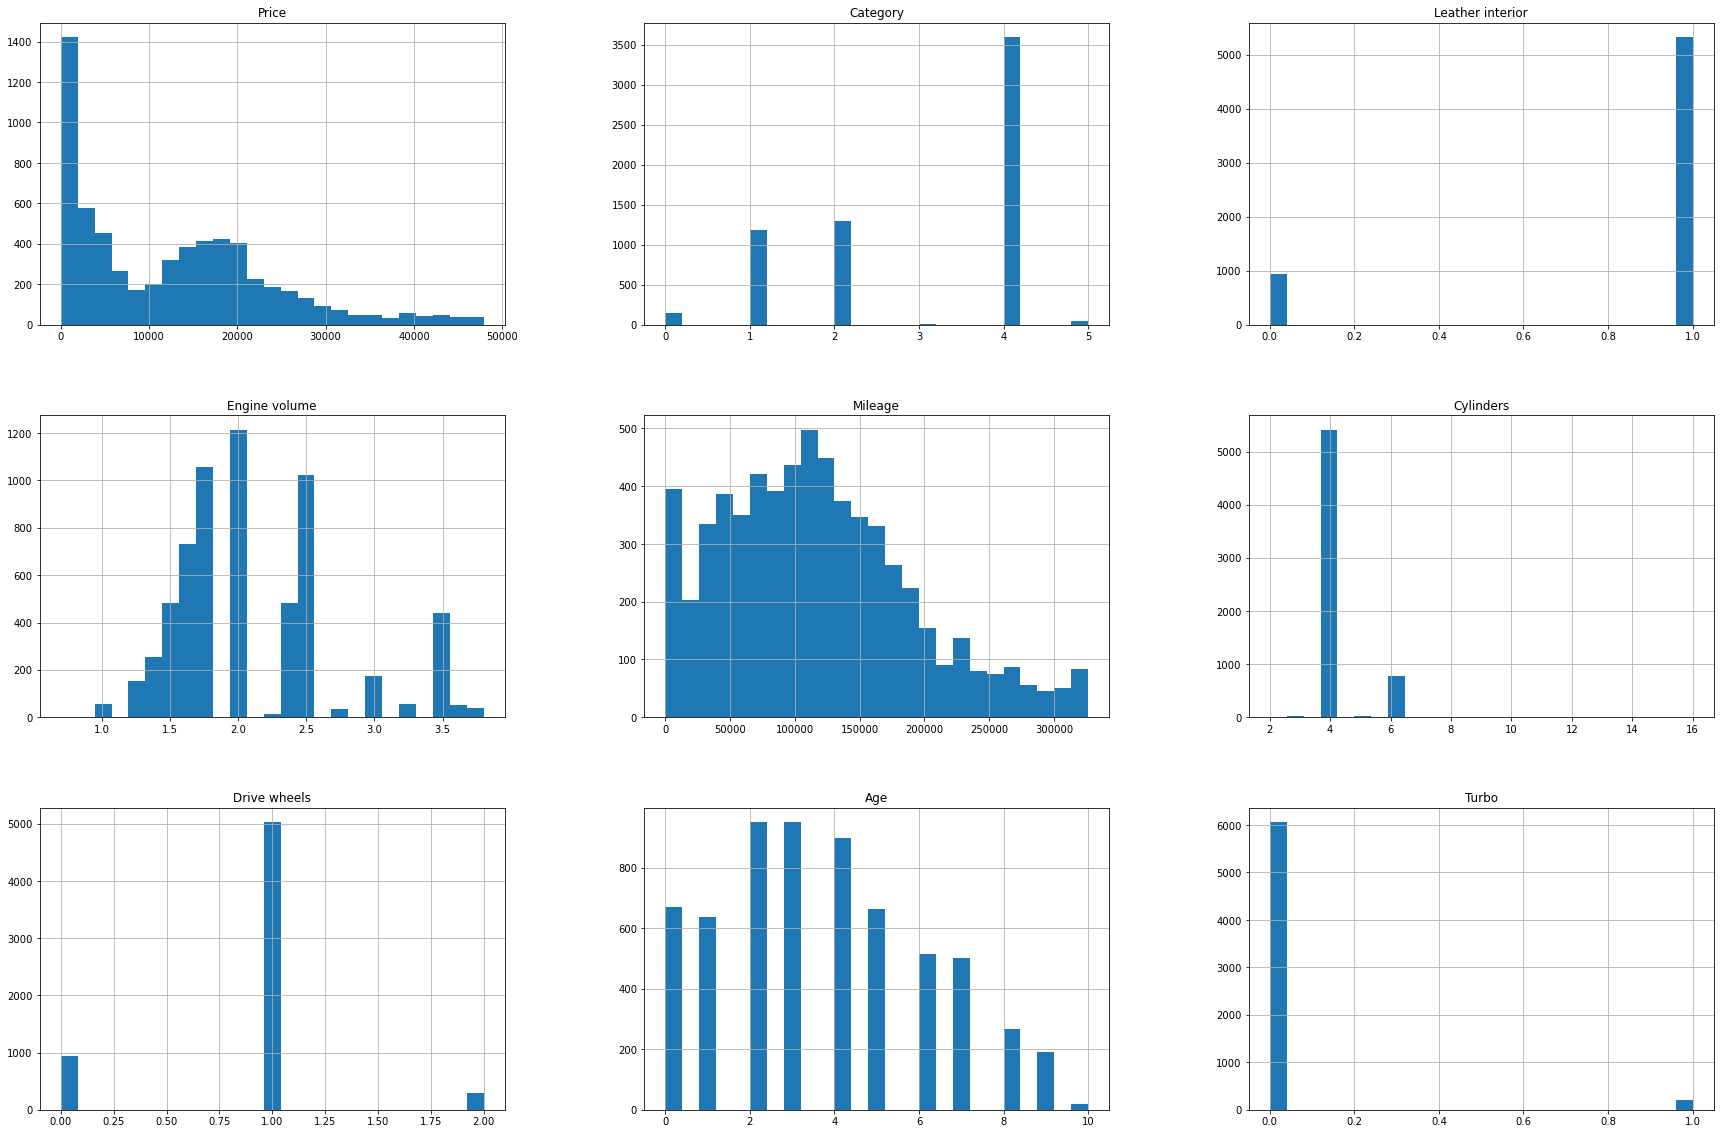

In [7]:
df.hist(bins=25,figsize=(30,20))
plt.show()

/Users/tianboyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


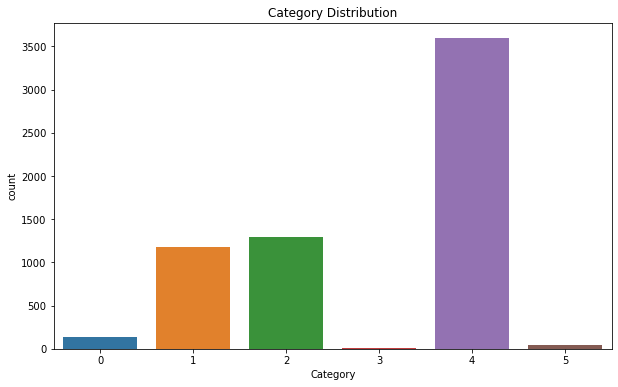

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(df['Category'])
plt.title('Category Distribution')
plt.show()

/Users/tianboyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


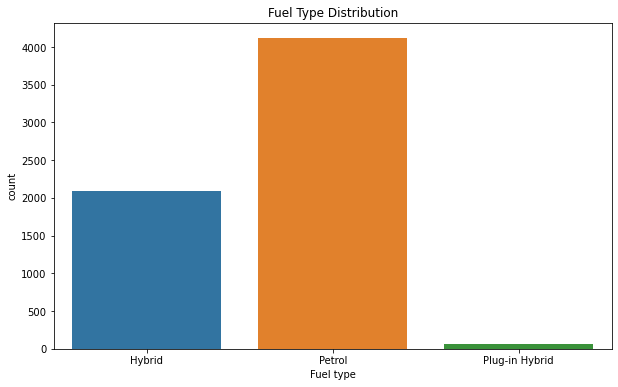

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(df['Fuel type'])
plt.title('Fuel Type Distribution')
plt.show()

Now let's take a look at the manufacturers. First we draw a histogram of the number of cars produced by each manufacturer. We can see from the graph that Toyota and Huyndai are two most significant manufacturers that contributes to a large proportion of data to the dataset. Since we have chosen to keep only the top 20 manufacturers, there are no apparent outliers from our dataset, which is an important factor to our consequent data analysis tasks.

/Users/tianboyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


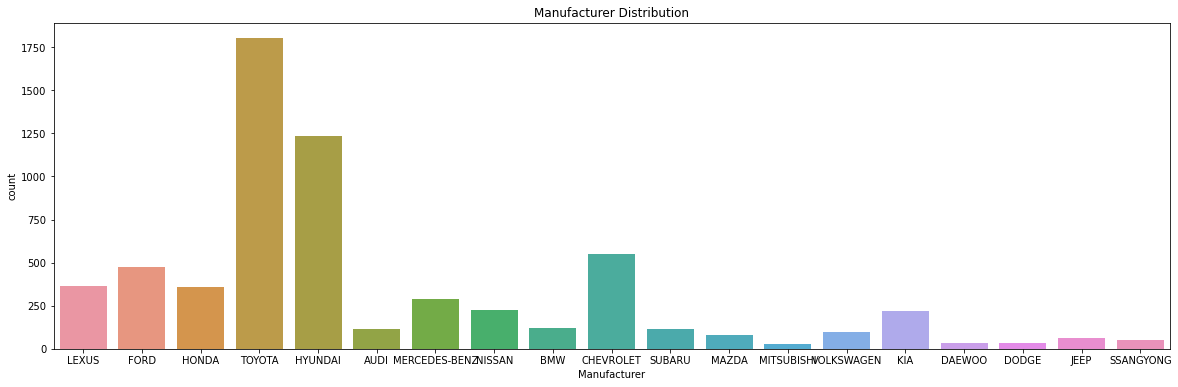

In [10]:
plt.figure(figsize=(20, 6))
sns.countplot(df['Manufacturer'])
plt.title('Manufacturer Distribution')
plt.show()

We can also show the average price of cars produced by each manufacturer in our selected dataset to get an overall impression of how expensive a car typically is in each manufacturer. There are also indicators of the variance for the cars' prices at the top of the bars in each manufacturer.

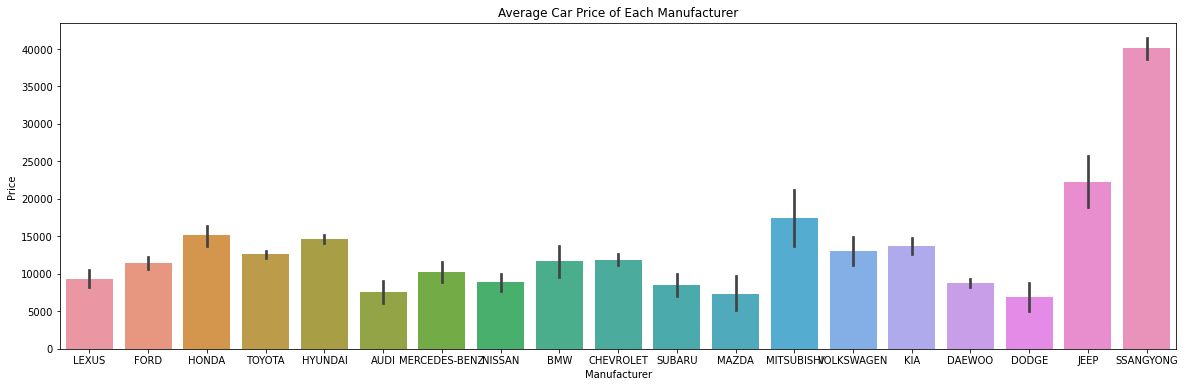

In [11]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Manufacturer', y='Price', data=df)
plt.title('Average Car Price of Each Manufacturer')
plt.show()

Here we have a correlation heatmap for attributes in the dataset. The numbers on the graph represents the correlation between the attributes on the corresponding row and column. For example, the two largest numbers in the heatmap are the relationship between Cylinders & Engine Volume and the relationship between Age & Mileage, which are known to be reasonable and strongly correlated. As shown on the graph, the attribute that is most closely related to a car's price is Mileage, which indicates that the value of Mileage hasa an impact of about -0.29 to the car's price. Other attributes has less positive/negative impact on the price of a car. 

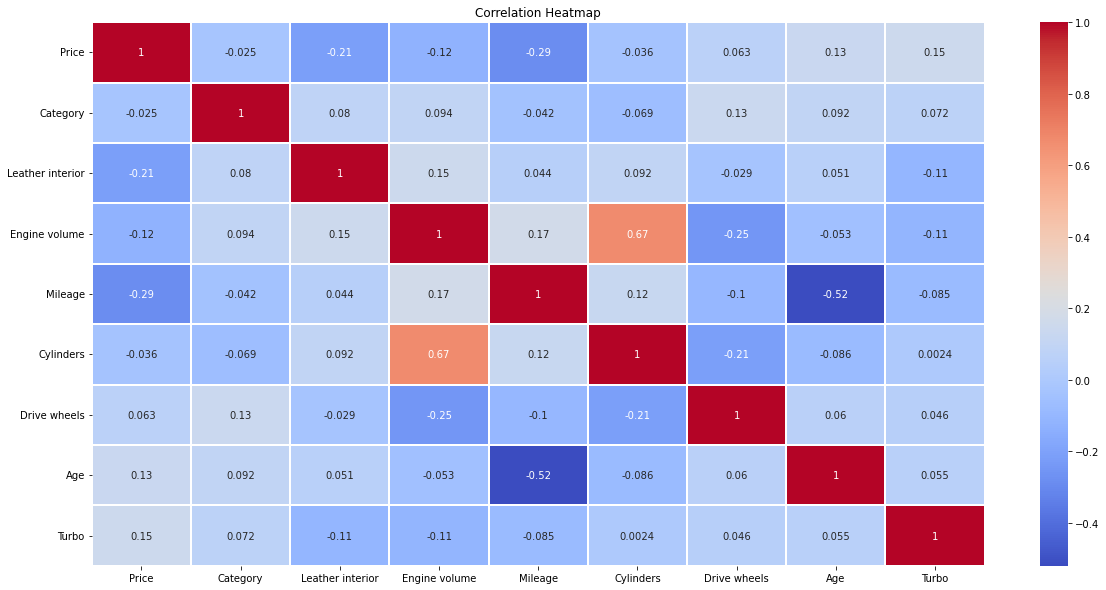

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

## Hypothesis test 1: 

### Is there a statistical difference between the prices of cars that run on standard petrol versus cars that are hybrid?

Text(0.5, 1.0, 'Distribution Prices of Hybrid Cars')

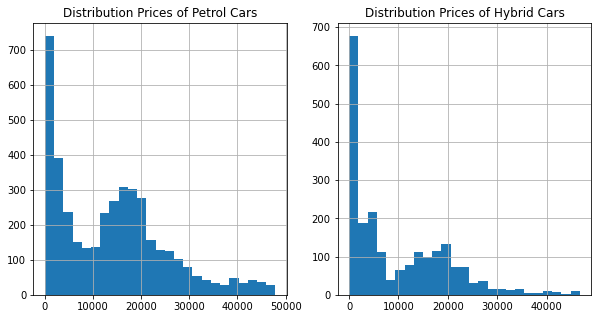

In [13]:
# dataframes for petrol and hybrid cars only
df_petrol = df[df['Fuel type'] == 'Petrol']
df_hybrid = df[df['Fuel type'].str.contains('Hybrid')]

# plotting individual distributions
fig, axes = plt.subplots(1, 2)

ax1 = df_petrol['Price'].hist(bins=25,figsize=(10,5), ax=axes[0])
ax1.set_title('Distribution Prices of Petrol Cars')

ax2 = df_hybrid['Price'].hist(bins=25,figsize=(10,5), ax=axes[1])
ax2.set_title('Distribution Prices of Hybrid Cars')

#### Hypotheses and Test Statistics
$H_0\text{: Prices of petrol fueled cars and hybrid cars come from the same distribution, and any difference is due to random chance.}$
$H_A\text{: Prices of hybrid fueled cars are lower than petrol cars, on average. The observed differences in our sample cannot be due to random chance alone.}$
$\text{Test Statistic: Mean of Petrol Car Prices - Mean of Hybrid Car Prices}$

In [14]:
def calc_test_stat(df, col_name):
    '''
    Function to calculate the test statistic for each permutation and the observed
    '''
    group_means = df.groupby(col_name)['Price'].mean()
    return group_means['Petrol'] - group_means['Hybrid']

In [15]:
# creating a copy of the original dataframe and categorizing 'Hybrid' and 'Plug-in Hybrid' as the same
df_test1 = df.copy()
df_test1['Fuel type'] = df_test1['Fuel type'].apply(lambda x: 'Hybrid' if x == 'Plug-in Hybrid' else x)

obs_test_stat = calc_test_stat(df_test1, 'Fuel type')
print('Observed Test Statistic: ' + str(obs_test_stat))

Observed Test Statistic: 4213.226521403789


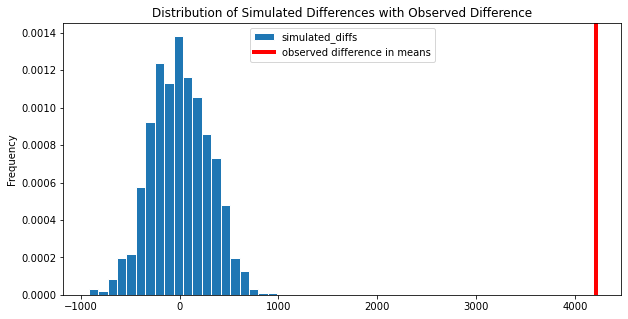

In [16]:
# computing 1000 test statistics from permutations of the fuel type in the dataframe
n_repetitions = 1000
differences = np.array([])

for i in np.arange(n_repetitions):
    shuffled_labels = np.random.permutation(df_test1['Fuel type'])
    shuffled = df_test1.assign(Shuffled_Labels=shuffled_labels)
    difference = calc_test_stat(shuffled, 'Shuffled_Labels')
    differences = np.append(differences, difference)

# plotting the distribution of the simulated test statistics and the observed test statistic
pd.DataFrame().assign(simulated_diffs=differences).plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
plt.axvline(obs_test_stat, color='red', linewidth=4, label='observed difference in means')
plt.title('Distribution of Simulated Differences with Observed Difference')
plt.legend()

In [17]:
p_val = np.count_nonzero(differences >= obs_test_stat) / n_repetitions
p_val

0.0

At a significance level of 0.01, we reject the null hypothesis, implying that the prices of hybrid cars and petrol cars do not come from the same distribution.

## Hypothesis test 2: 

### Is there a significant difference between car prices for cars of different drive wheel orientations?

Text(0.5, 1.0, 'Distribution Prices of Rear-wheel Drive Cars')

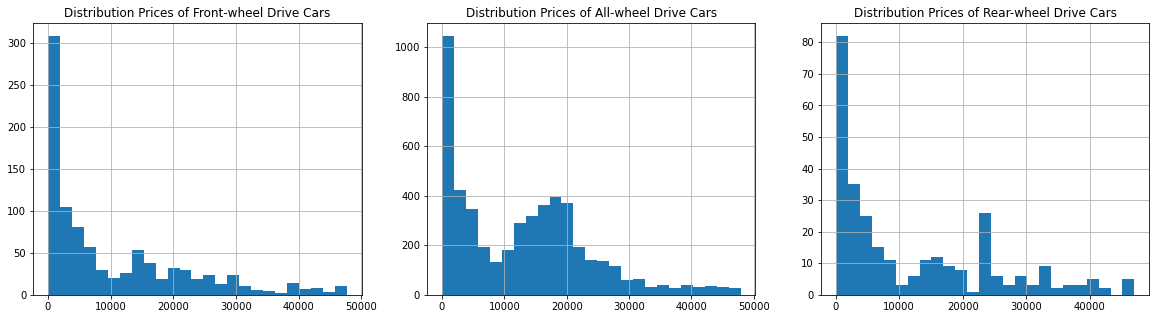

In [18]:
# dataframes for petrol and hybrid cars only
df_front = df[df['Drive wheels'] == 0]
df_4by4 = df[df['Drive wheels'] == 1]
df_rear = df[df['Drive wheels'] == 2]

# plotting individual distributions
fig, axes = plt.subplots(1, 3)

ax1 = df_front['Price'].hist(bins=25,figsize=(20,5), ax=axes[0])
ax1.set_title('Distribution Prices of Front-wheel Drive Cars')

ax2 = df_4by4['Price'].hist(bins=25,figsize=(20,5), ax=axes[1])
ax2.set_title('Distribution Prices of All-wheel Drive Cars')

ax3 = df_rear['Price'].hist(bins=25,figsize=(20,5), ax=axes[2])
ax3.set_title('Distribution Prices of Rear-wheel Drive Cars')

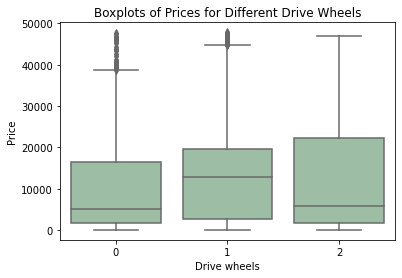

In [19]:
ax = sns.boxplot(x='Drive wheels', y='Price', data=df, color='#99c2a2')
ax.set_title('Boxplots of Prices for Different Drive Wheels')
plt.show()

#### Hypotheses and Test Statistics
$H_0: \mu_0 = \mu_1 = \mu_2$ <br>
$H_A\text{: All }\mu\text{ are not equal.}$ <br>
$\text{Test Statistic: F statistic}$

In [20]:
fvalue, pvalue = stats.f_oneway(df_front['Price'], df_4by4['Price'], df_rear['Price'])
fvalue, pvalue

(22.233854316039796, 2.3883872850911397e-10)

At a significance level of 0.01, we fail to reject the null hypothesis, implying that there doesn't seem to be a significant difference between the prices of cars across the diffferent drive wheel types.

## Regression model: 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
df.head()

,Price,Manufacturer,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Drive wheels,Age,Turbo
0,14727,LEXUS,2,1,Hybrid,3.5,186005.0,6.0,0,0,0
3,4469,FORD,2,1,Hybrid,2.5,168966.0,4.0,0,1,0
4,12172,HONDA,1,1,Petrol,1.3,91901.0,4.0,1,4,0
6,2564,TOYOTA,1,1,Hybrid,1.8,258909.0,4.0,1,0,0
7,1300,HYUNDAI,4,1,Petrol,2.4,216118.0,4.0,1,3,0


In [23]:
df_encoded = pd.get_dummies(df, columns=['Manufacturer', 'Fuel type'])
df_encoded.head()

,Price,Category,Leather interior,Engine volume,Mileage,Cylinders,Drive wheels,Age,Turbo,Manufacturer_AUDI,...,Manufacturer_MERCEDES-BENZ,Manufacturer_MITSUBISHI,Manufacturer_NISSAN,Manufacturer_SSANGYONG,Manufacturer_SUBARU,Manufacturer_TOYOTA,Manufacturer_VOLKSWAGEN,Fuel type_Hybrid,Fuel type_Petrol,Fuel type_Plug-in Hybrid
0,14727,2,1,3.5,186005.0,6.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4469,2,1,2.5,168966.0,4.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,12172,1,1,1.3,91901.0,4.0,1,4,0,0,...,0,0,0,0,0,0,0,0,1,0
6,2564,1,1,1.8,258909.0,4.0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7,1300,4,1,2.4,216118.0,4.0,1,3,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
X = df_encoded.drop(['Price', 'Drive wheels'], axis=1)
y = df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Linear Regression

In [25]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [26]:
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("Linear Regression RMSE:", np.sqrt(lr_mse))
print("Linear Regression R^2:", lr_r2)

Linear Regression RMSE: 9488.663525013664
Linear Regression R^2: 0.23012065939324133


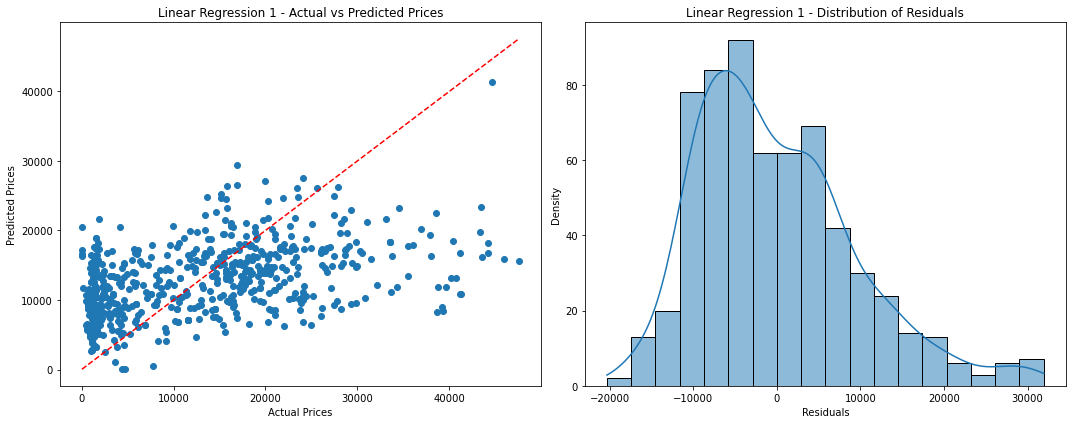

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, lr_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Linear Regression 1 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - lr_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Linear Regression 1 - Distribution of Residuals')

plt.tight_layout()
plt.show()

The performance for the linear model is not very good, so we want to try polynomia regression for better fitting of our data

### Polynomial Regression

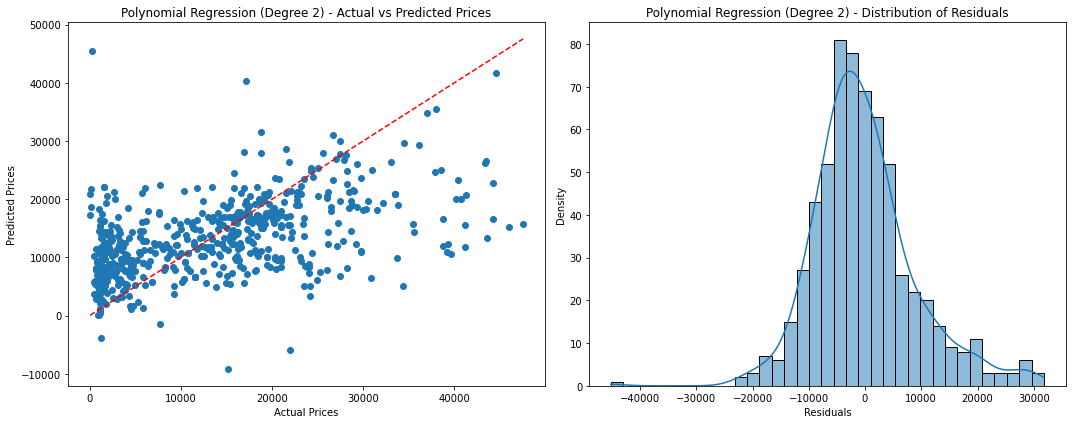

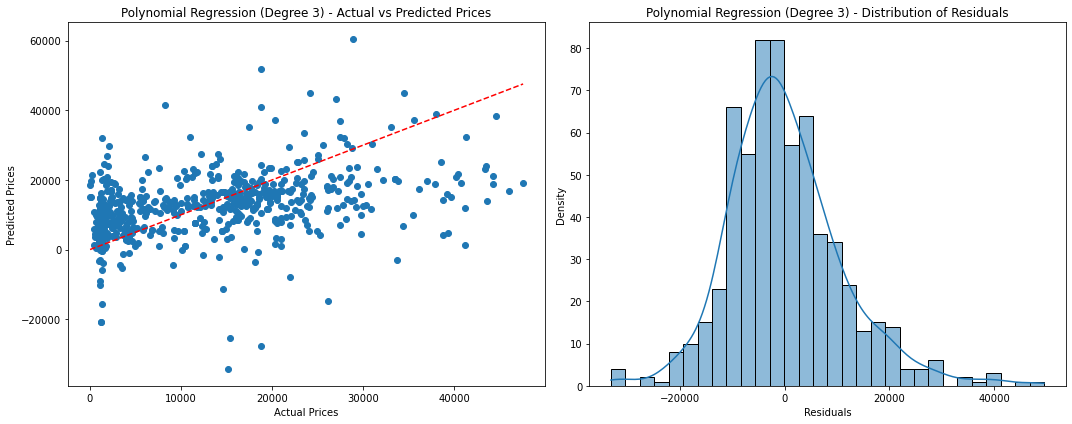

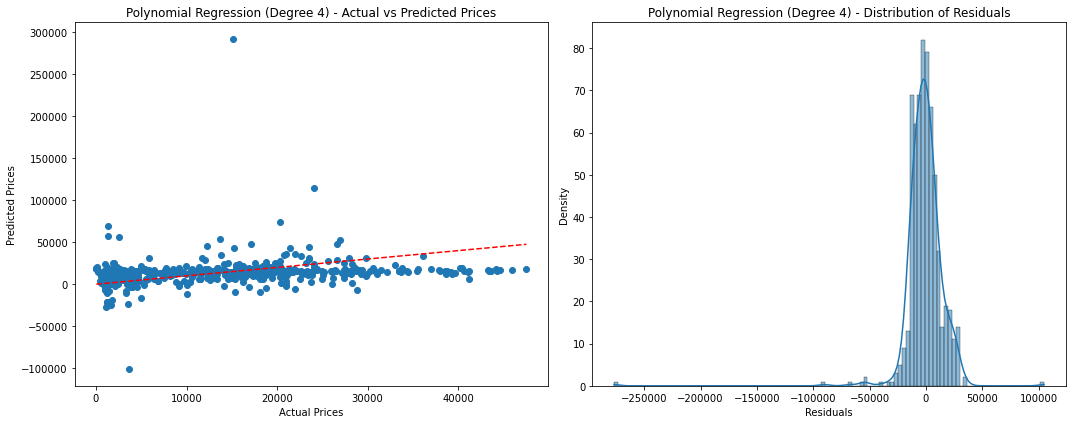

Polynomial Regression RMSE: [9098.942377238476, 11039.276109345208, 17427.83947837121]
Polynomial Regression R^2: [0.2920633408159258, -0.04206249244979099, -1.5971657975965163]


In [30]:
from sklearn.preprocessing import PolynomialFeatures

rmses = []
r2s = []

for degree in range(2, 5):
    poly_transformer = PolynomialFeatures(degree=degree)

    X_train_poly = poly_transformer.fit_transform(X_train)
    X_test_poly = poly_transformer.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    y_pred = poly_model.predict(X_test_poly)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotting Actual vs Predicted Prices
    axes[0].scatter(y_test, y_pred)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0].set_xlabel('Actual Prices')
    axes[0].set_ylabel('Predicted Prices')
    axes[0].set_title(f'Polynomial Regression (Degree {degree}) - Actual vs Predicted Prices')
    
    # Plotting Distribution of Residuals
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=axes[1])
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Density')
    axes[1].set_title(f'Polynomial Regression (Degree {degree}) - Distribution of Residuals')
    
    plt.tight_layout()
    plt.show()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    rmses.append(rmse)
    r2s.append(r2)

print(f'Polynomial Regression RMSE: {rmses}')
print(f'Polynomial Regression R^2: {r2s}')

The performance of the model improved when using polynomial regression. When degree = 2, the mse decreased and r2_score increased, indicating that the model is better than linear, but when the degree continues to increase, the performance becomes much worse, meaning that we have over-fitting issue when degree > 2.

### Decision Tree Regression

Although some improvements are made using polynomial regression, we are still not satisfied with the result, then we thought of using decision tree regression, which is chosen for its ability to capture non-linear relationships and interactions between variables without requiring feature scaling or transformation. It's intuitive and easily interpretable, making it a potential better tool for understanding how different features influence the output.

In [31]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()

dt_model.fit(X_train, y_train)

dt_predictions = dt_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("Decision Tree Regression RMSE:", np.sqrt(dt_mse))
print("Decision Tree Regression R^2:", dt_r2)

Decision Tree Regression RMSE: 8659.479962996153
Decision Tree Regression R^2: 0.35879603982711417


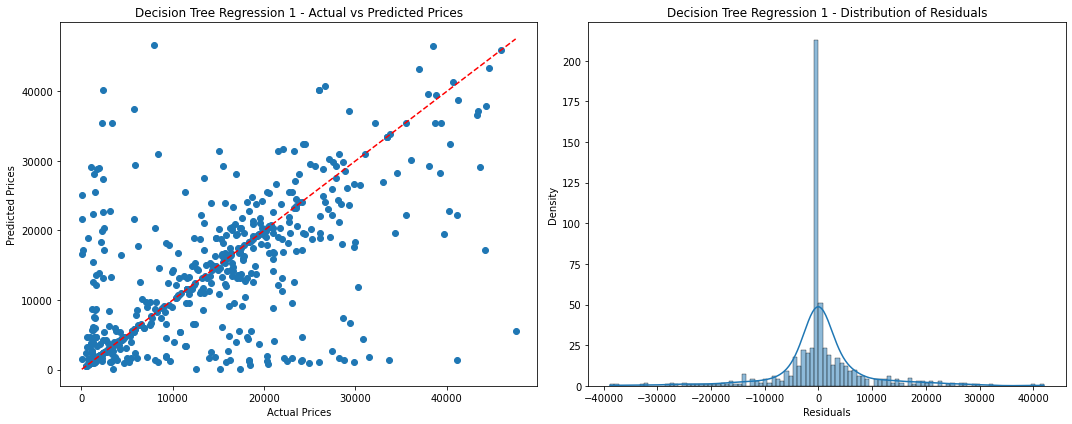

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, dt_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Decision Tree Regression 1 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - dt_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Decision Tree Regression 1 - Distribution of Residuals')

plt.tight_layout()
plt.show()


The performance of the decision tree regression is still not significantly better than linear and polynomial regression, fails to meet the expectation. We need to think of another regression model to improve the performance.

### Random Forest Regression

Random Forest Regression is an ensemble method using multiple decision trees, is recommended due to its high accuracy, robustness to overfitting, and ability to handle non-linear data effectively. By aggregating the predictions of numerous trees, it improves prediction stability and accuracy, making it well-suited for complex datasets with a large number of features and potential interactions. This method is particularly beneficial for capturing the intricate relationships within car data, providing a deeper understanding of factors affecting car prices while mitigating the variance and bias associated with individual decision trees.

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Regression RMSE:", np.sqrt(rf_mse))
print("Random Forest Regression R^2:", rf_r2)

Random Forest Regression RMSE: 7192.33004037223
Random Forest Regression R^2: 0.557664506873434


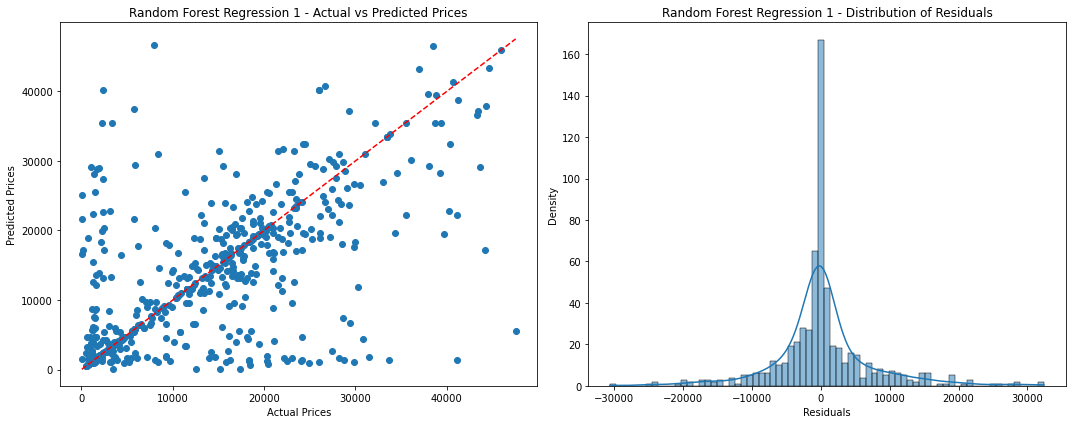

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, dt_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Random Forest Regression 1 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - rf_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Random Forest Regression 1 - Distribution of Residuals')

plt.tight_layout()
plt.show()

In [35]:
w = rf_model.feature_importances_

feature_names = X.columns
for feature, weight in zip(feature_names, w):
    print(f"{feature}: {weight}")

Category: 0.049130477498805745
Leather interior: 0.05204565280039501
Engine volume: 0.10668921494692414
Mileage: 0.3854428858097525
Cylinders: 0.021405213620287772
Age: 0.1272490517944277
Turbo: 0.02064981271826226
Manufacturer_AUDI: 0.004553434966475763
Manufacturer_BMW: 0.004076286632938672
Manufacturer_CHEVROLET: 0.01244454303335177
Manufacturer_DAEWOO: 0.00045556312990781506
Manufacturer_DODGE: 0.00024132068585345934
Manufacturer_FORD: 0.00855854125836002
Manufacturer_HONDA: 0.019579692137185918
Manufacturer_HYUNDAI: 0.02471030103326032
Manufacturer_JEEP: 0.010745865661104154
Manufacturer_KIA: 0.004991685962943996
Manufacturer_LEXUS: 0.010397041459092277
Manufacturer_MAZDA: 0.002786262640282508
Manufacturer_MERCEDES-BENZ: 0.007741982733465301
Manufacturer_MITSUBISHI: 0.0013450801334322878
Manufacturer_NISSAN: 0.006428680992611987
Manufacturer_SSANGYONG: 0.05096833076687315
Manufacturer_SUBARU: 0.003975684119392983
Manufacturer_TOYOTA: 0.021118825076128202
Manufacturer_VOLKSWAGEN: 0

The Random Forest Regression model has achieved a promising RMSE of 7037 and an R² value of 0.576, indicating a moderate level of accuracy and explanatory power in predicting car prices based on their characteristics. These results underscore the model's effectiveness in capturing the complex, non-linear relationships between various car features and their market prices. By leveraging an ensemble of decision trees, the model reduces overfitting, enhances prediction stability, and offers valuable insights into how different attributes—ranging from engine size to production year—affect car valuations. By accurately predicting car prices based on comprehensive characteristics, this model serves as a powerful tool for consumers, enabling them to make more informed purchasing decisions. It helps buyers assess the fair market value of vehicles, ensuring they pay a price that accurately reflects a car's features and condition. For sellers, it provides insights into how various car attributes influence price, aiding in competitive pricing strategies. Additionally, the model's insights can guide consumers towards vehicles that offer the best value for their needs and budget, ultimately enhancing customer satisfaction and trust in the automotive market.

### Moving Forward with regerssion

Now we want to focus on one manufacturer, which is Toyota since it has the most instances of data, to do the regressions that we did above and see if there are any improvements with the performance

In [36]:
df['Manufacturer'].value_counts()

TOYOTA           1802
HYUNDAI          1234
CHEVROLET         552
FORD              476
LEXUS             363
HONDA             361
MERCEDES-BENZ     291
NISSAN            225
KIA               221
BMW               121
SUBARU            116
AUDI              115
VOLKSWAGEN         95
MAZDA              79
JEEP               60
SSANGYONG          53
DODGE              34
DAEWOO             33
MITSUBISHI         30
Name: Manufacturer, dtype: int64

In [37]:
manufacturer_most_cars = df['Manufacturer'].value_counts().index[0]
df_most_cars = df[df['Manufacturer'] == manufacturer_most_cars]
df_most_cars = pd.get_dummies(df_most_cars, columns=['Fuel type'])

In [38]:
X = df_most_cars.drop(['Price', 'Manufacturer'], axis=1)
y = df_most_cars['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [39]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("Linear Regression RMSE:", np.sqrt(lr_mse))
print("Linear Regression R^2:", lr_r2)

Linear Regression RMSE: 10198.809008742686
Linear Regression R^2: 0.25039061557122333


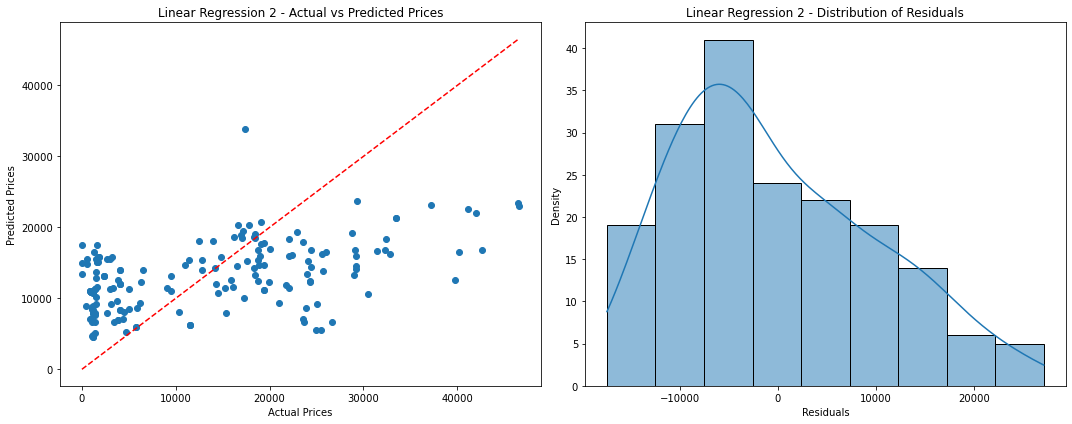

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, lr_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Linear Regression 2 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - lr_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Linear Regression 2 - Distribution of Residuals')

plt.tight_layout()
plt.show()

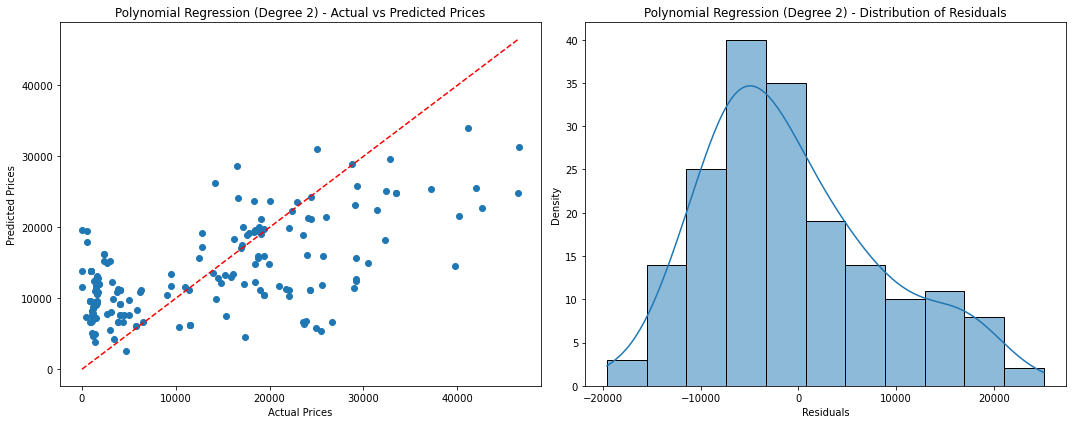

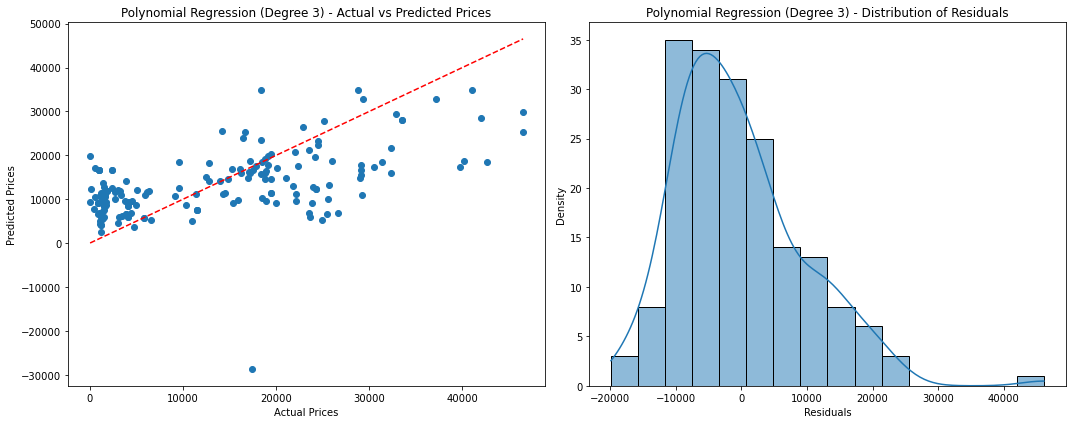

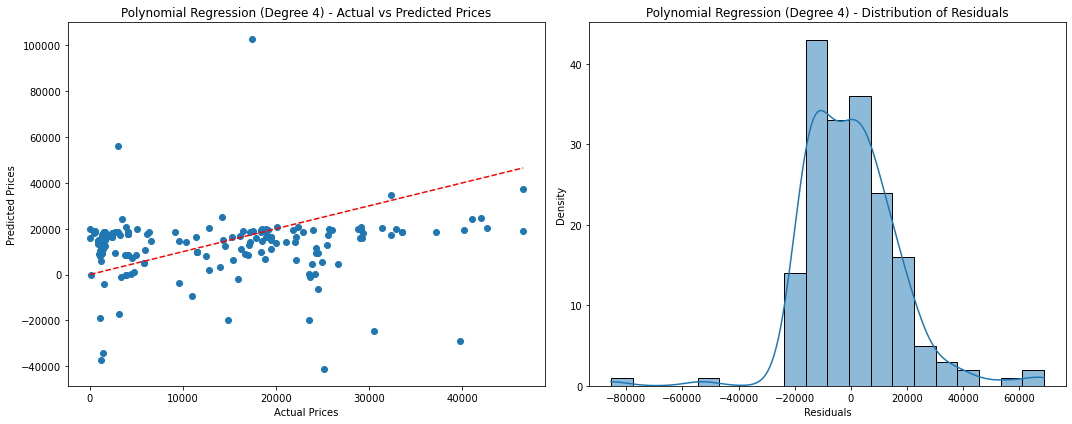

Polynomial Regression MSE: [83198835.12280008, 94886246.40857755, 296491217.8881161]
Polynomial Regression R^2: [0.40041143341202334, 0.3161838337152211, -1.1367215547798168]


In [41]:
mses = []
r2s = []

for degree in range(2, 5):
    poly_transformer = PolynomialFeatures(degree=degree)

    X_train_poly = poly_transformer.fit_transform(X_train)
    X_test_poly = poly_transformer.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    y_pred = poly_model.predict(X_test_poly)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plotting Actual vs Predicted Prices
    axes[0].scatter(y_test, y_pred)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0].set_xlabel('Actual Prices')
    axes[0].set_ylabel('Predicted Prices')
    axes[0].set_title(f'Polynomial Regression (Degree {degree}) - Actual vs Predicted Prices')
    
    # Plotting Distribution of Residuals
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=axes[1])
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Density')
    axes[1].set_title(f'Polynomial Regression (Degree {degree}) - Distribution of Residuals')
    
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mses.append(mse)
    r2s.append(r2)

print(f'Polynomial Regression MSE: {mses}')
print(f'Polynomial Regression R^2: {r2s}')

In [47]:
dt_model = DecisionTreeRegressor()

dt_model.fit(X_train, y_train)

dt_predictions = dt_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("Decision Tree Regression RMSE:", np.sqrt(dt_mse))
print("Decision Tree Regression R^2:", dt_r2)

Decision Tree Regression RMSE: 8823.069939121293
Decision Tree Regression R^2: 0.43898362105201016


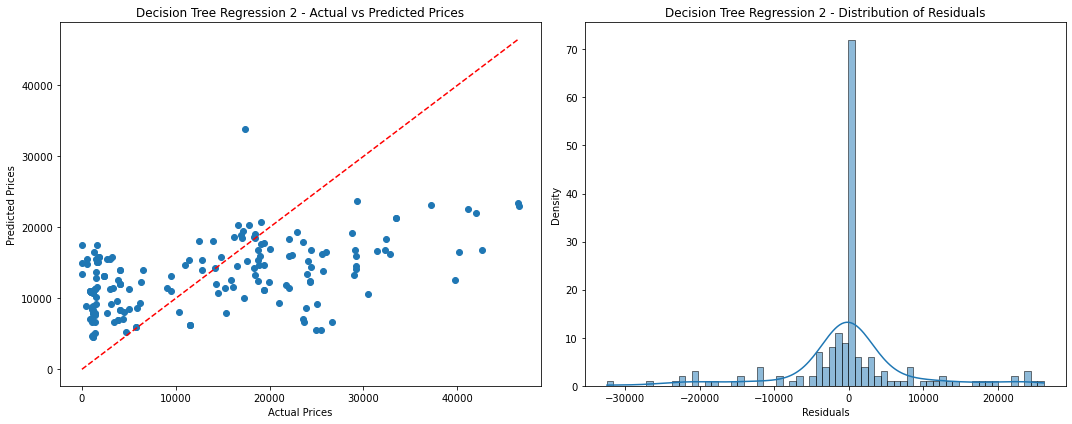

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, lr_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Decision Tree Regression 2 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - dt_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Decision Tree Regression 2 - Distribution of Residuals')

plt.tight_layout()
plt.show()

In [51]:
rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Regression RMSE:", np.sqrt(rf_mse))
print("Random Forest Regression R^2:", rf_r2)

Random Forest Regression RMSE: 7100.8100682336235
Random Forest Regression R^2: 0.6366276398079515


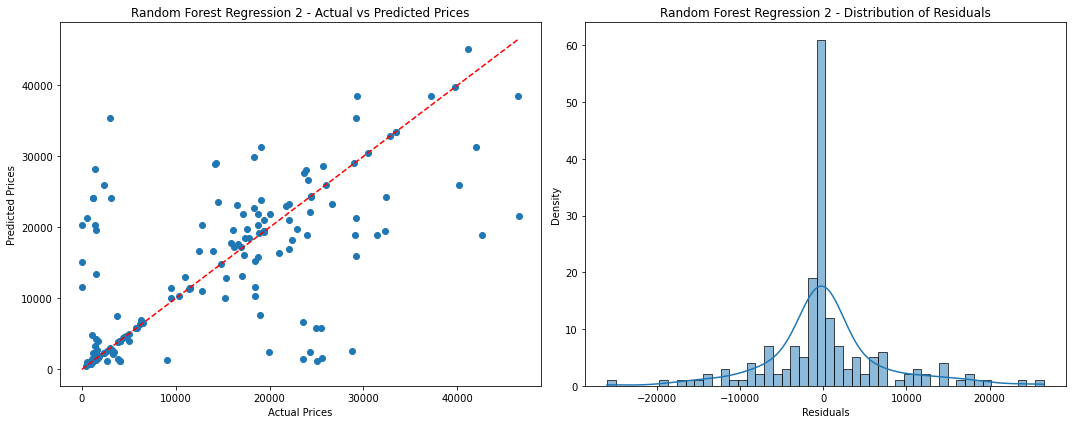

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Actual vs Predicted Prices
axes[0].scatter(y_test, dt_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Random Forest Regression 2 - Actual vs Predicted Prices')

# Plotting Distribution of Residuals
residuals = y_test - rf_predictions
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Random Forest Regression 2 - Distribution of Residuals')

plt.tight_layout()
plt.show()

In [46]:
w = rf_model.feature_importances_

feature_names = X.columns
for feature, weight in zip(feature_names, w):
    print(f"{feature}: {weight}")

Category: 0.04265847571062601
Leather interior: 0.1072347391779616
Engine volume: 0.13692298431330494
Mileage: 0.4363430643864618
Cylinders: 0.0387893613008114
Drive wheels: 0.024919469285726633
Age: 0.171691554304599
Turbo: 0.00045544147714221555
Fuel type_Hybrid: 0.024011223824767555
Fuel type_Petrol: 0.014439838087273876
Fuel type_Plug-in Hybrid: 0.0025338481313248403


As we can see from the result of these regressions, if we select one specific manufacturer and want to predict the price for its cars, the performance of the models are noticably better than before. This result can help people better understand and forsee the future prices of the cars they intend to buy if they have decided which manufacturer they want to buy the car from.